# NLP Problem: Part of Speech Tagging for arabic language 
<u>Requirements</u>
1. Use of the datasets PADT, <u>**PUD**</u> or NYUAD
2. Implement 2 models : a DL model and a pre-DL model
3. I need good performance of a model at least better than 50% (random chance)


## Understand the nature of the dataset and problem

- Taken from [Universal Dependencies](https://universaldependencies.org/), I using the [Arabic PUD](https://universaldependencies.org/treebanks/ar_pud/index.html) (github[\*](https://github.com/UniversalDependencies/UD_Arabic-PUD))
- Uses articles from Wikipedia(W) and the news(N)
- Data is sequential (sequence of word) therefore use seq2seq model and analysis <br>

# Pre-DL model Chosen : KNN
##### The KNN is a non-sequential multi-class classifier


## Load the libraries

In [76]:
import conllu
import matplotlib.pyplot as plt
import pandas as pd
import re
import seaborn as sns
import numpy as np
#encode the corpus to numbers
import tensorflow as tf
import gensim

#preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

#build the SVM
from sklearn.neighbors import KNeighborsClassifier


#performance evaluation
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import plot_confusion_matrix

## Read Data
- Interacting with CoNLL-U annotations in Python
- Importing conllu, a small library for **parsing CoNLL-U annotations** into various data structures native to Python.
- [Usefull tutorial](https://www.youtube.com/watch?v=lvJRFMvWtFI) with [github page](https://github.com/Applied-Language-Technology/notebooks/blob/main/part_iii/06_text_linguistics.ipynb) 

In [2]:
with open("..\\Universal Dependencies 2.10\\UD_Arabic-PUD\\ar_pud-ud-test.conllu", mode="r", encoding="utf-8") as data:

    #read the file contents and assign under 'annotations'
    annotations=data.read()

#check the type of the resulting object
print(type(annotations))
annotations[1:1000]

<class 'str'>


' newdoc id = n01001\n# sent_id = n01001011\n# text = كتبت كوري شولمان, المساعدة الخاصة لأوباما في تدوينة نشرتها يوم الإثنين: "فيما الكثير من عمليات الانتقال الرقمي غير مسبوقة في الولايات المتحدة, فإن الانتقال السلمي للسلطة سبق له أن حدث".\n# original_text = كتبت كوري شولمان, المساعدة الخاصة لأوباما في تدوينة نشرتها يوم الإثنين: "فيما الكثير من عمليات الانتقال الرقمي غير مسبوقة في الولايات المتحدة, فإن الانتقال السلمي للسلطة سبق له أن حدث".\n# text_en = “While much of the digital transition is unprecedented in the United States, the peaceful transition of power is not,” Obama special assistant Kori Schulman wrote in a blog post Monday.\n1\tكتبت\tkatab-u_1\tVERB\tVBC\tAspect=Perf|Gender=Fem|Number=Sing|Person=3|Tense=Past|Voice=Act\t0\troot\t_\t_\n2\tكوري\tkwry_0\tPROPN\tNNP\tAnimacy=Hum|Case=Nom|Gender=Fem|Number=Sing\t1\tnsubj\t_\t_\n3\tشولمان\t$wlmAn_0\tPROPN\tNNP\tAnimacy=Hum|Gender=Masc|Number=Sing\t2\tflat\t_\tSpaceAfter=No\n4\t,\t,_0\tPUNCT\t,\t_\t5\tpunct\t_\t_\n5\tالمساعدة\tmus

In [3]:
#parse the string of annotations to sentences
sentences = conllu.parse(annotations)

In [4]:
print(type(sentences))
sentences[0].metadata #metadata is simply a dictionary type
#meta data has 5 keys:newdoc id ,sent_id,text,original_text,text_en

<class 'conllu.models.SentenceList'>


{'newdoc id': 'n01001',
 'sent_id': 'n01001011',
 'text': 'كتبت كوري شولمان, المساعدة الخاصة لأوباما في تدوينة نشرتها يوم الإثنين: "فيما الكثير من عمليات الانتقال الرقمي غير مسبوقة في الولايات المتحدة, فإن الانتقال السلمي للسلطة سبق له أن حدث".',
 'original_text': 'كتبت كوري شولمان, المساعدة الخاصة لأوباما في تدوينة نشرتها يوم الإثنين: "فيما الكثير من عمليات الانتقال الرقمي غير مسبوقة في الولايات المتحدة, فإن الانتقال السلمي للسلطة سبق له أن حدث".',
 'text_en': '“While much of the digital transition is unprecedented in the United States, the peaceful transition of power is not,” Obama special assistant Kori Schulman wrote in a blog post Monday.'}

In [5]:
sentences[0][0]
#each sentence is a row , sentences[sentence_indx][:]
# to access each word within the sentence's pos, use sentences[sentence_indx][word_indx]['upos']

{'id': 1,
 'form': 'كتبت',
 'lemma': 'katab-u_1',
 'upos': 'VERB',
 'xpos': 'VBC',
 'feats': {'Aspect': 'Perf',
  'Gender': 'Fem',
  'Number': 'Sing',
  'Person': '3',
  'Tense': 'Past',
  'Voice': 'Act'},
 'head': 0,
 'deprel': 'root',
 'deps': None,
 'misc': None}

Q: why to put index in each dict?<br>A: to avoid using the key as the word nor the tag cuz both are not unique<br>
### Preprocessing Tasks for the data PUD:
1. Remove tanween and tashkeel
2. Remove non-arabic words
Note : according to the sentences extracted from the dataset no lemmetization is applied nor arabic stopwords are removed

#### Create corpus

In [6]:
def remove_tashkeel(w):
    #remove tashkeel
    p_tashkeel = re.compile(r'[\u0617-\u061A\u064B-\u0652]')
    w = re.sub(p_tashkeel,"", w)
    return w

In [7]:
#create a corpus : list of dictionaries, each dict is a sentence
corpus=[]
list_pos=[]
list_words=[]
pos=[]
list_sentences=[]
for sentence in sentences:
    word_dict={}
    sentence_txt=sentence.metadata['text']
    re_pattern = re.compile(r'[a-zA-Z]+')
    if re_pattern.search(sentence_txt)== None:
        list_sentences.append(sentence_txt)
        pos_bfr=[]
        for w_indx in range(len(sentence)):
            word_str=remove_tashkeel(sentence[w_indx]['form'])
            word_pos=sentence[w_indx]['upos']
            pos_bfr.append(word_pos)
            list_pos.append(word_pos)
            list_words.append(word_str)
            word_dict[w_indx]=[word_str,word_pos,sentence_txt,len(sentence_txt)]
        pos.append(pos_bfr)
        corpus.append(word_dict)

In [8]:
#report the info of the cleaned corpus
print("The corpus has {} sentences".format(len(corpus)))

The corpus has 998 sentences


In [28]:
#save the results in a dataframe 
df_w = pd.DataFrame (list_words, columns = ['w_name'])
df = pd.DataFrame (list_pos, columns = ['tag_name'])
df_w.to_csv("word_list_cleaned.csv", encoding="utf-8")
df.to_csv("tag_list.csv", encoding="utf-8")

[Text(0, 0, '5553'),
 Text(0, 0, '3564'),
 Text(0, 0, '2221'),
 Text(0, 0, '2021'),
 Text(0, 0, '1780'),
 Text(0, 0, '1722'),
 Text(0, 0, '1295'),
 Text(0, 0, '646'),
 Text(0, 0, '566'),
 Text(0, 0, '401'),
 Text(0, 0, '368'),
 Text(0, 0, '187'),
 Text(0, 0, '165'),
 Text(0, 0, '152'),
 Text(0, 0, '30'),
 Text(0, 0, '5')]

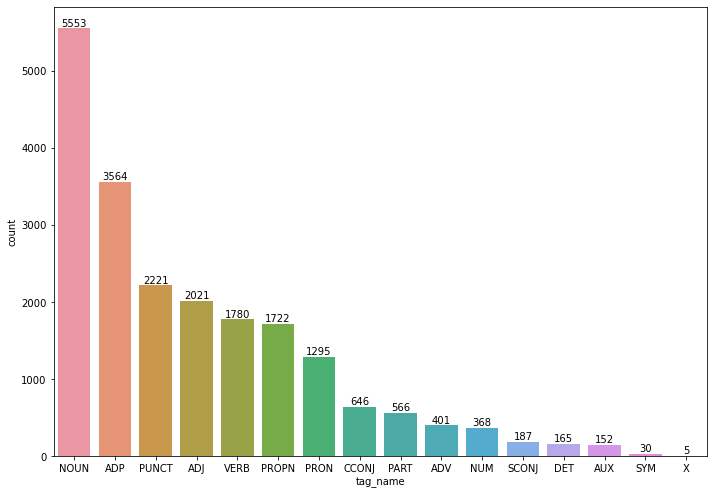

In [10]:
#plot the found tags with popularity of each in the corpus
fig, ax = plt.subplots()
# the size of A4 paper
fig.set_size_inches(11.7, 8.27)
ax = sns.countplot(x=df['tag_name'],
                   order=df['tag_name'].value_counts(ascending=False).index);

abs_values = df['tag_name'].value_counts(ascending=False).values

ax.bar_label(container=ax.containers[0], labels=abs_values)

#### Label Encode the output
Label encode the tags

In [89]:
print("- The number of unique tags is {}, \n- The list of tags: {}".format(len(df['tag_name'].unique()),df['tag_name'].unique()))
le = LabelEncoder()
le_tags = le.fit_transform(df['tag_name']) #type =numpy.ndarray
print("- The values are min = {} and max {}".format(le_tags.min(),le_tags.max()))

- The number of unique tags is 16, 
- The list of tags: ['VERB' 'PROPN' 'PUNCT' 'NOUN' 'ADJ' 'ADP' 'PRON' 'ADV' 'PART' 'AUX' 'DET'
 'SCONJ' 'CCONJ' 'NUM' 'X' 'SYM']
- The values are min = 0 and max 15


In [90]:
le_tags.shape

(20676,)

#### Embedding Representation of  sentences
directly embedding (previously we tokenized, labeled to padd the sequence but no need here since we will feed word by word)


In [91]:
#list of words in the dictionary
#embedding_model.wv.index_to_key

In [92]:
embedding_model = gensim.models.Word2Vec.load('full_uni_sg_300_twitter.mdl')
embeddings = {}
for word,vector in zip(embedding_model.wv.index_to_key,embedding_model.wv):
    coefs =[]
    coefs.append(vector)
    embeddings[word] = coefs

In [93]:
def transform2SkipGram(data,embeddings, emb_dime):
    emb_size=len(data)
    embeddings_weights = np.zeros((emb_size, emb_dime))
    for i,word in enumerate(data):
        embedding_vector = embeddings.get(word)
        if embedding_vector is not None:
            embeddings_weights[i] = embedding_vector[0]
    return embeddings_weights
embedded_input=transform2SkipGram(list_words,embeddings,300)

In [94]:
print('The input of size = {} is replaced with \nthe embedding representation of size = {}'.format(len(list_words),embedded_input.shape))


The input of size = 20676 is replaced with 
the embedding representation of size = (20676, 300)


## Split the data into training and testing
- Ratio : 70%training-30%testing

In [95]:
total_samples=le_tags.shape[0]
train_samples=round(total_samples* 0.7)

indices = np.random.permutation(total_samples)
training_idx, test_idx = indices[:train_samples], indices[train_samples:]
train_x, test_x = embedded_input[training_idx,:], embedded_input[test_idx,:]
train_y, test_y = le_tags[training_idx], le_tags[test_idx]

## Create & Train KNN Model

In [96]:
print("The records are split to {}-training and {}-testing".format(train_x.shape[0], test_x.shape[0]))

The records are split to 14473-training and 6203-testing


##### Create the model

In [97]:
knn = KNeighborsClassifier(5)
knn.fit(train_x, train_y)

KNeighborsClassifier()

## Performance Evaluation

1. accuracy, recall, precision, and f1 measure,
2. confusion matrix
3. learning curve

In [98]:
pred_y = knn.predict(test_x)
pred_labels = le.inverse_transform(pred_y)
accuracy = accuracy_score(test_y, pred_y)
precision = precision_score(test_y, pred_y, average='weighted')
recall = recall_score(test_y, pred_y, average='weighted')
F1 = 2 * (precision * recall) / (precision + recall)
print("Accuracy = {0:.2f}".format(accuracy))
print("Precision = {0:.2f}".format(precision))
print("Recall = {0:.2f}".format(recall))
print("F1- Score = {0:.2f}".format(F1))

Accuracy = 0.67
Precision = 0.71
Recall = 0.67
F1- Score = 0.69


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [101]:
df['tag_name'].values.tolist()

['VERB',
 'PROPN',
 'PROPN',
 'PUNCT',
 'NOUN',
 'ADJ',
 'ADP',
 'PROPN',
 'ADP',
 'NOUN',
 'VERB',
 'PRON',
 'ADV',
 'PROPN',
 'PUNCT',
 'PUNCT',
 'ADP',
 'NOUN',
 'ADP',
 'NOUN',
 'NOUN',
 'ADJ',
 'PART',
 'ADJ',
 'ADP',
 'PROPN',
 'ADJ',
 'PUNCT',
 'PART',
 'PART',
 'NOUN',
 'ADJ',
 'ADP',
 'NOUN',
 'VERB',
 'ADP',
 'PRON',
 'ADP',
 'VERB',
 'PUNCT',
 'PUNCT',
 'ADP',
 'NOUN',
 'ADP',
 'PRON',
 'PRON',
 'VERB',
 'NOUN',
 'ADJ',
 'ADP',
 'NOUN',
 'NOUN',
 'ADJ',
 'ADP',
 'PROPN',
 'PROPN',
 'PUNCT',
 'PART',
 'AUX',
 'NOUN',
 'ADJ',
 'DET',
 'NOUN',
 'PUNCT',
 'ADP',
 'ADJ',
 'ADP',
 'NOUN',
 'PRON',
 'ADJ',
 'ADP',
 'NOUN',
 'NOUN',
 'ADP',
 'NOUN',
 'PUNCT',
 'VERB',
 'NOUN',
 'ADJ',
 'SCONJ',
 'PRON',
 'ADP',
 'NOUN',
 'PART',
 'VERB',
 'PUNCT',
 'ADP',
 'NOUN',
 'ADJ',
 'PUNCT',
 'ADP',
 'NOUN',
 'ADJ',
 'ADP',
 'NOUN',
 'PUNCT',
 'NOUN',
 'NOUN',
 'PUNCT',
 'PUNCT',
 'VERB',
 'ADP',
 'NOUN',
 'PRON',
 'VERB',
 'ADP',
 'DET',
 'NOUN',
 'ADJ',
 'ADJ',
 'ADP',
 'PROPN',
 'PROPN',
 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


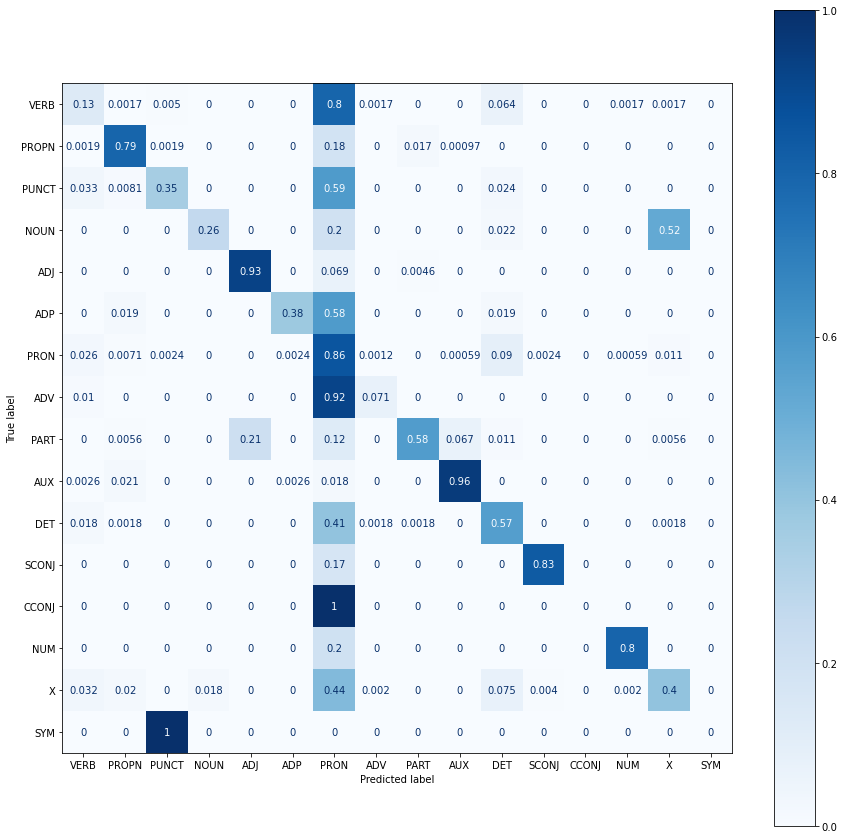

In [102]:
#confusion matrix
fig, ax = plt.subplots(figsize=(15, 15))
plot_confusion_matrix(knn, test_x, test_y,normalize='true', cmap=plt.cm.Blues, ax=ax) 
ax.xaxis.set_ticklabels(df['tag_name'].unique()); ax.yaxis.set_ticklabels(df['tag_name'].unique());
plt.show()